## Problem Definition

In this document we will discuss how we can use US financial data to try to dynamically forecast
the prices of liquid assets (stocks) using time series data and Machine Learning algorithms. The
main idea is to create multiple Machine Learning models that will be continuously fed with daily
public data, from which they will be able to learn patterns and predict the stock price for the
next day of any given ticker. We will use publicly available time series data which includes a
merge of stock prices and trade volume from Yahoo Finance, economic data from the Federal
Reserve and some data engineered as part of this work. The main purpose of this document is to
demonstrate how we can approach time series predictions using Machine Learning, but also to
check if some variables included in our analysis, such as interest rates and money supply, affect
the price of the financial assets as stated in some modern economic theories.<br><br>

We are going to use the following features to feed our Machine Learning models:<br>
<b>Stock Price:</b> Based on daily data from Yahoo Finance. We will use both the S&P500 index<br>
and the stock we will build the model for. This is going to be our target variable.<br>
<b>Trade Volume:</b> Based on daily data from Yahoo Finance. We will use both the S&P500 index
and the stock we will build the model for. Included to measure the impact of liquidity on the
stock price.<br>
<b>M2 Money Supply:</b> Based on monthly data from Board of Governors of the Federal Reserve
System (US). Included to measure the impact of the money circulating in the economy on the
stock price.<br>
<b>Interest rates:</b> Based on monthly data from Board of Governors of the Federal Reserve System
(US). Included to measure the impact of the interest rates on the stock price.<br>
<b>RSI and MA:</b> We will use periods 14, 30, 50 and 200. These features will be engineered as
part of this work but are based on daily data from Yahoo Finance. Included to measure the
impact of technical factors on the stock price.<br>
<b>Google Trends:</b> Based on weekly data that measure the searching volume of the stock ticker
in Google site. Included to measure the impact of the news on the stock price.<br>
<b>Other Engineered Features:</b> We will include the percentage change in trade volume and percentage
change in stock returns.
These features will be engineered as part of this work but are based on daily data from Yahoo
Finance.

In [1]:
#Libraries to dynamically get datasets
from yahoofinancials import YahooFinancials
import yfinance as yf
from pytrends.request import TrendReq

#Data manipulation and math libraries
import pandas as pd
import numpy as np
import talib
from datetime import date, timedelta
import datetime

#Plotting library
import matplotlib.pyplot as plt

#Machine Learning libraries
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

import warnings

In [2]:
#Setup stock initial variables
stock_ticker = "MSFT"
features = ['Close','Volume']

#Setting plot size
plt.rcParams['figure.figsize'] = [20, 10]

## Data Quality

-We are going to get financial and economic data, some of which is indexed as monthly and some other as open-market days.<br>
-We are making the respective changes so all data have a DateTime index which is required for time series data analysis.<br>
-We are going to interpolate monthly data and adjust it to match the open-market days.<br>
This means we are importing and handling the NaN values in one step.

In [3]:
#Get stock data
ticker = yf.Ticker(stock_ticker)
stock = ticker.history(period="max")[features]
stock.columns = ['close_stock','volume_stock']

#Get SP500 data and merge with stock data
ticker = yf.Ticker("^GSPC")
sp500 = ticker.history(period="max")[features].reindex(stock.index)
sp500.columns = ['close_sp500','volume_sp500']
df = pd.concat([stock,sp500],axis=1)

#Get M2 data and merge with stock data
m2 = pd.read_csv('M2SL.csv',parse_dates=['DATE'],index_col='DATE')
m2 = m2.reindex(df.index).interpolate()
m2.columns = ['m2_supply']
df = pd.concat([df,m2],axis=1)

#Get rates data and merge with stock data
rates = pd.read_csv('FEDFUNDS.csv',parse_dates=['DATE'],index_col='DATE')
rates = rates.reindex(df.index).interpolate()
rates.columns = ['fed_rate']
df = pd.concat([df,rates],axis=1)

#Get google trends and merge with stock data
pytrends = TrendReq(hl='en-US', tz=360)
kw_list = [stock_ticker]
pytrends.build_payload(kw_list, cat=0,timeframe='all')
trends = pytrends.interest_over_time().iloc[:,0]
trends.name = 'google_trend'
trends = trends.reindex(pd.date_range(start=trends.index[0],end=date.today())).interpolate()
trends = trends.reindex(df.index)
df = pd.concat([df,trends],axis=1)

#Inspect last 5 rows of raw data
df.tail()

,close_stock,volume_stock,close_sp500,volume_sp500,m2_supply,fed_rate,google_trend
Date,,,,,,,
2021-11-30,330.589996,42885600,4567.000000,4950190000,20982.9,0.08,39.066667
2021-12-01,330.079987,33337600,4513.040039,4078260000,20982.9,0.08,39.000000
2021-12-02,329.489990,30735500,4577.100098,3771510000,20982.9,0.08,39.000000
2021-12-03,323.010010,41755900,4538.430176,3971500000,20982.9,0.08,39.000000
2021-12-06,323.815002,11746539,4595.330078,1215630000,20982.9,0.08,39.000000


## Exploratory Data Analysis

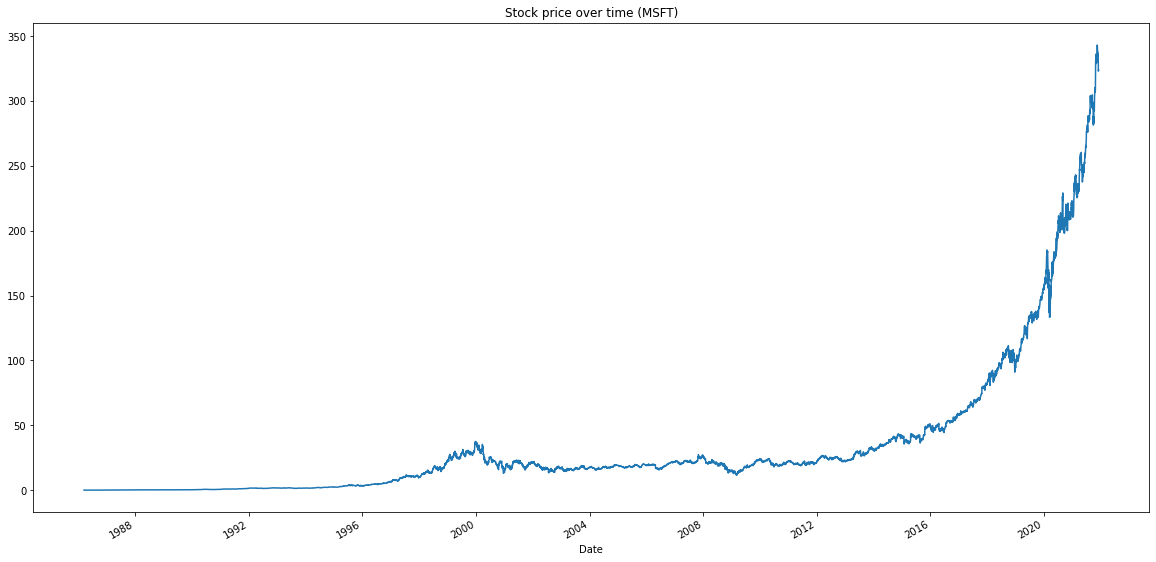

In [4]:
#Generate plot for EDA
df['close_stock'].plot()
plt.title('Stock price over time ({})'.format(stock_ticker))
plt.show()

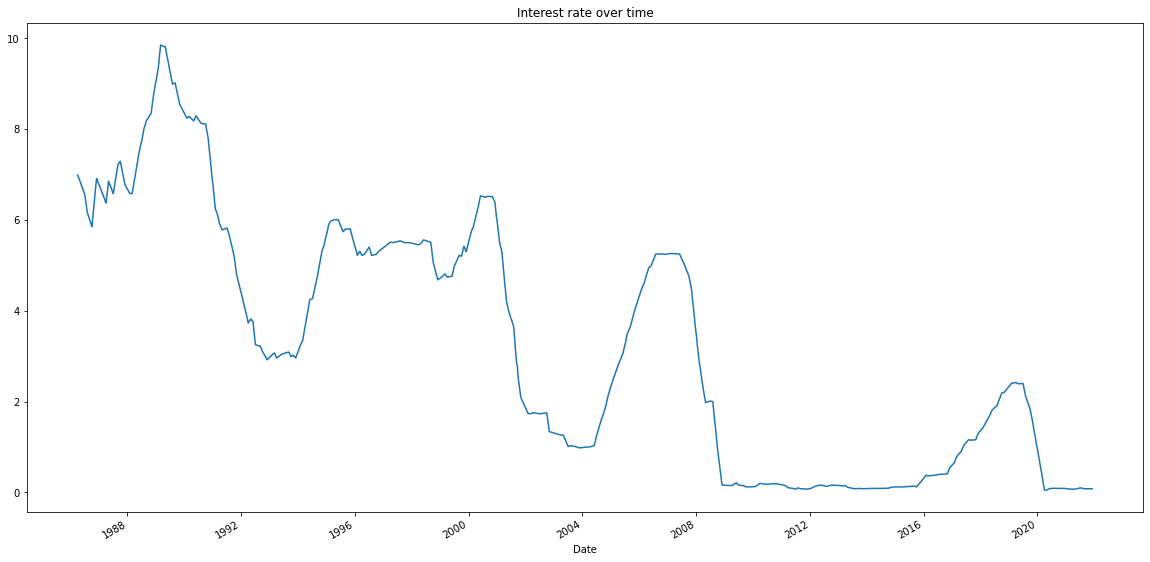

In [5]:
#Generate plot for EDA
df['fed_rate'].plot()
plt.title('Interest rate over time')
plt.show()

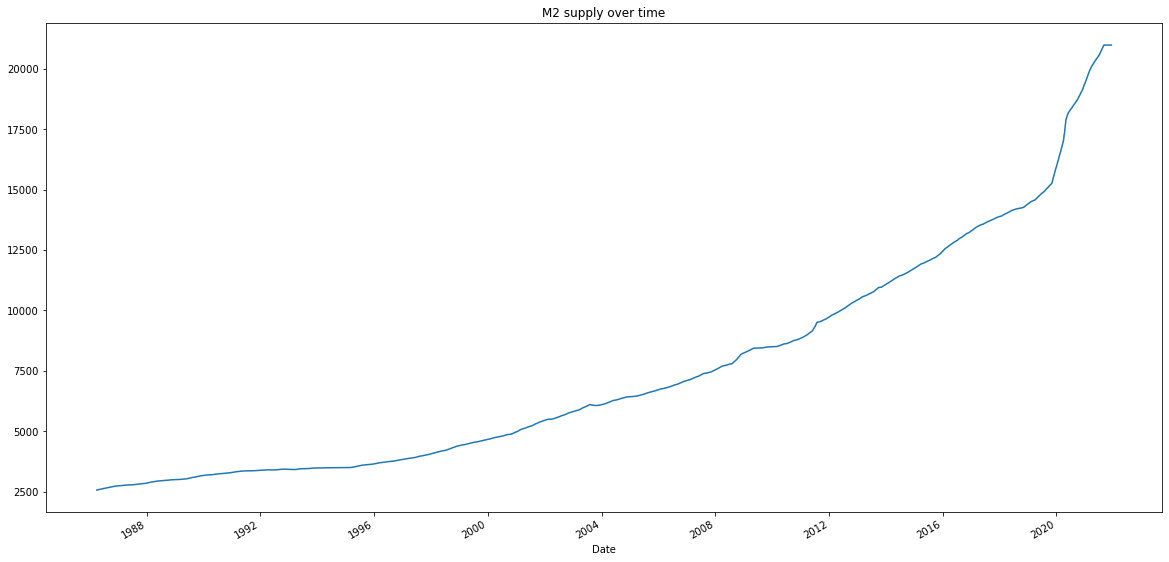

In [6]:
#Generate plot for EDA
df['m2_supply'].plot()
plt.title('M2 supply over time')
plt.show()

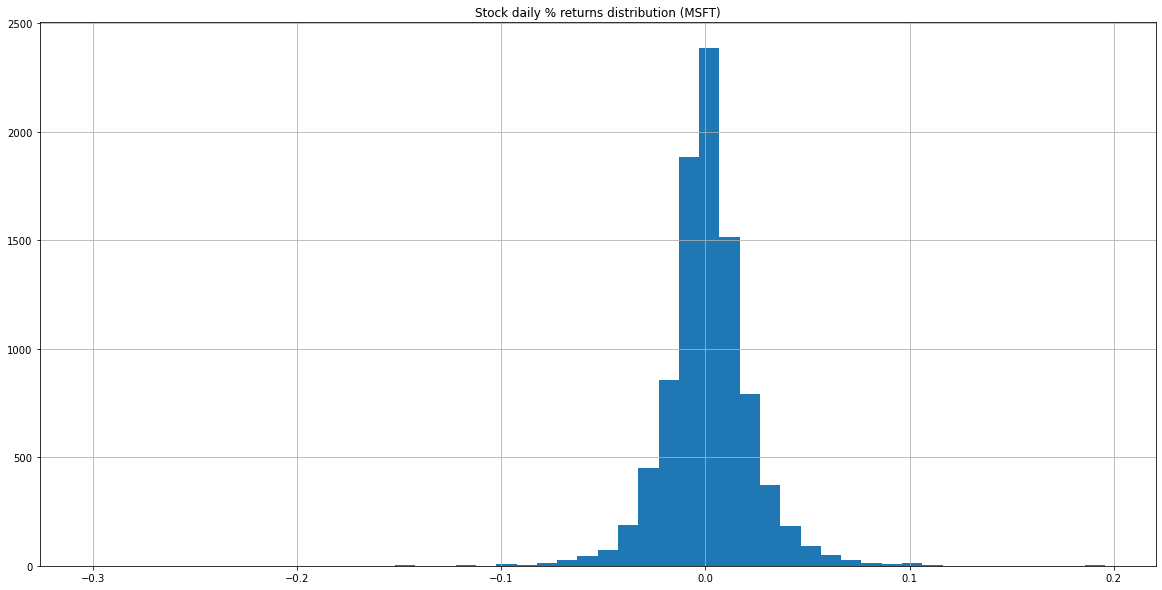

In [7]:
#Generate plot for EDA
df['close_stock'].pct_change().hist(bins=50)
plt.title('Stock daily % returns distribution ({})'.format(stock_ticker))
plt.show()

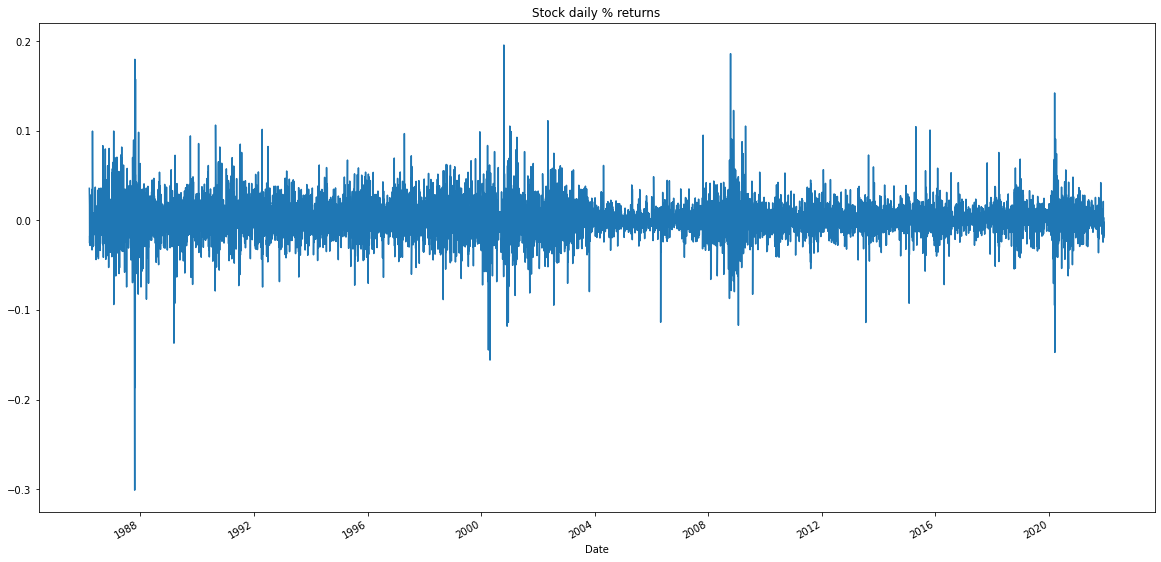

In [8]:
#Generate plot for EDA
df['close_stock'].pct_change().plot()
plt.title('Stock daily % returns')
plt.show()

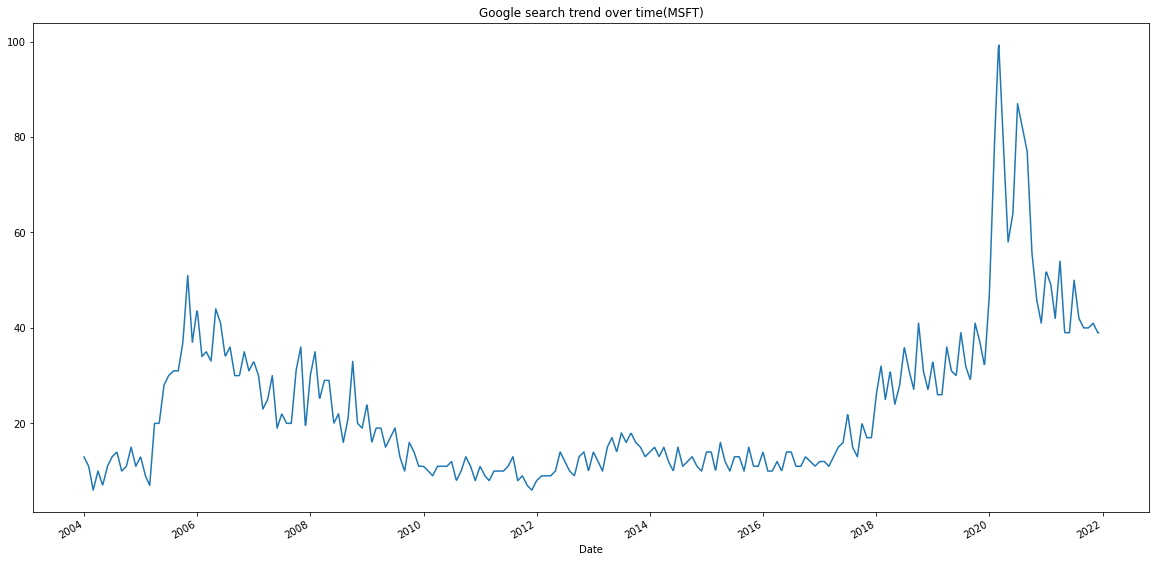

In [9]:
#Generate plot for EDA
df['google_trend'].plot()
plt.title('Google search trend over time({})'.format(stock_ticker))
plt.show()

### Descriptive Statistics returns
The last plots regarding stock returns are interesting since the returns seem to be normally distributed with mean close to zero and a small value for the standard deviation. I am printing some descriptive statistics for the returns to confirm this assumption.

In [10]:
df['close_stock'].pct_change().describe()

count    9007.000000
mean        0.001180
std         0.021314
min        -0.301159
25%        -0.009121
50%         0.000365
75%         0.011258
max         0.195652
Name: close_stock, dtype: float64

Based on the Exploratory Data Analysis, we can see that most of the data follow a Random Walk with shift and trend, which make it difficult to make predictions out of it. We can also see that applyin the percentage change to them will most likely make them stationary which will help us to build a better model. <b>Based on the EDA, I decided to change the target variable to predict the percentage dialy change of the stock price (aka returns) which seems to be a stationary feature.</b> The price on level (aka price) seems to be a Random Walk so this is discarded as target variable.

## Feature Engineering

In [11]:
#Generate RSI and MA for close_stock field for multiple periods
for n in [14,30,50,200]:
    # Normalize MA for better perfomance
    df['ma' + str(n)] = talib.SMA(df['close_stock'].values,timeperiod=n) / df['close_stock']
    # Create the RSI indicator
    df['rsi' + str(n)] = talib.RSI(df['close_stock'].values, timeperiod=n)
    
#Generate stock percentage change
df['volume_stock_pct_change_1d'] = df['volume_stock'].pct_change()

#Generate target variable stock return change (next_day_pct_change)
df['next_day_pct_change'] = df['close_stock'].shift(-1).pct_change()

#Inspect the new features
df.tail()

,close_stock,volume_stock,close_sp500,volume_sp500,m2_supply,fed_rate,google_trend,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200,volume_stock_pct_change_1d,next_day_pct_change
Date,,,,,,,,,,,,,,,,,
2021-11-30,330.589996,42885600,4567.000000,4950190000,20982.9,0.08,39.066667,1.017292,51.417442,0.995566,58.031683,0.952257,59.541024,0.833897,58.047433,0.501413,-0.001543
2021-12-01,330.079987,33337600,4513.040039,4078260000,20982.9,0.08,39.000000,1.018838,50.811095,0.999367,57.688703,0.955899,59.318763,0.836508,57.990280,-0.222639,-0.001787
2021-12-02,329.489990,30735500,4577.100098,3771510000,20982.9,0.08,39.000000,1.020157,50.075412,1.003447,57.283542,0.959520,59.058522,0.839329,57.923972,-0.078053,-0.019667
2021-12-03,323.010010,41755900,4538.430176,3971500000,20982.9,0.08,39.000000,1.037727,42.753670,1.024900,53.050309,0.980255,56.290821,0.857459,57.201999,0.358556,0.002492
2021-12-06,323.815002,11746539,4595.330078,1215630000,20982.9,0.08,39.000000,1.032579,43.851986,1.023919,53.491993,0.979363,56.548945,0.856729,57.268496,-0.718686,0.000000


## Machine Learning

In [12]:
#Generate X matrix and y vector for ML models, from start_period
start_period = '2000-01-01'
#Define if market is still open for the current day
is_market_open = True

#Remove missing values and slice from start period
df = df.dropna()[start_period:] 

#Remove the last sample if the market is still open since it will only contain partial information for the given day
if is_market_open: 
    df = df[:-1]
    
#Define X features and y targets
X = df.drop(['next_day_pct_change'],axis=1)
y = df['next_day_pct_change']

#Initialize an array in which we will save the predictions
predictions = np.array([]) 

#Get the actual change of the last sample in the DataFrame for comparison purposes in our prediction
actual_change = (df.iloc[-1]['next_day_pct_change'] * 100)

### Train and Test set definition
We are going to use all data that is in our preprocessed DataFrame but the last 20 open-market days to train our model. Therefore, the test set will be the last 20 days which will be divided in 4 incremental slices to include 5, 10, 15 and 20 samples and get the score metric for each one of the slices to check how well the model generalizes to new data. The score metric for the training set, the 4 test slices and the average of these 4 slices will be printed, along with the prediction for the last sample (i.e. last open-market day) in the data.

In [13]:
#Define function to create sets
def get_train_test_sets(X,y,test_size,scaled=False):     
    X_train = X.iloc[:-test_size]    
    X_test = X.iloc[-test_size:]
    y_train = y.iloc[:-test_size]
    y_test = y.iloc[-test_size:]    
    if scaled is True:
        scaler = StandardScaler()        
        X_train = pd.DataFrame(scaler.fit_transform(X_train),index=X_train.index,columns=X.columns)        
        X_test = pd.DataFrame(scaler.transform(X_test),index=X_test.index,columns=X.columns)
    return  X_train,y_train,X_test,y_test

#Define function to train and evaluate models, and return the prediction for last row in dataset
def train_and_evaluate(model,X,y,scaled=False):
    test_size_in_days = 20
    period_size = int(test_size_in_days / 4)
    X_train, y_train,X_test, y_test  = get_train_test_sets(X,y,test_size_in_days,scaled=scaled)        
    model.fit(X_train,y_train)    
    print('R2 score for training set is {:.2f}'.format(r2_score(y_train,model.predict(X_train))))
    r2_scores = []
    for test_slice in range(period_size, test_size_in_days+1, period_size):     
        slice_start = y_test.index[0].strftime('%Y-%m-%d')
        slice_end = y_test[:test_slice].index[-1].strftime('%Y-%m-%d')            
        score=r2_score(y_test[:test_slice],model.predict(X_test[:test_slice]))
        print('R2 score for test slice from {} to {} is {:.2f}'.format(slice_start,slice_end,score))
        r2_scores.append(score)        
    print('Average R2 score for test set is {:.2f}'.format(np.mean(r2_scores)))
    prediction = model.predict(X_test.iloc[-1:])[0] * 100
    day = X_test.iloc[-1].name.strftime('%Y-%m-%d')    
    print('Prediction change for stock '+stock_ticker + ' on the next open-market day after '\
          + day + ' is: {:.2f}%'.format(prediction))    
    if scaled is False:
        plot_feature_importances(model)    
    return prediction
    
#Define function to plot feature importances
def plot_feature_importances(model):    
    importances = model.feature_importances_    
    sorted_index = np.argsort(importances)[::-1]
    x = range(len(importances))    
    labels = np.array(model.feature_names_in_)[sorted_index]
    plt.bar(x, importances[sorted_index], tick_label=labels)    
    plt.xticks(rotation=90)
    plt.show()

R2 score for training set is 0.87
R2 score for test slice from 2021-11-05 to 2021-11-11 is 0.07
R2 score for test slice from 2021-11-05 to 2021-11-18 is -0.01
R2 score for test slice from 2021-11-05 to 2021-11-26 is -0.22
R2 score for test slice from 2021-11-05 to 2021-12-03 is -0.36
Average R2 score for test set is -0.13
Prediction change for stock MSFT on the next open-market day after 2021-12-03 is: -0.06%


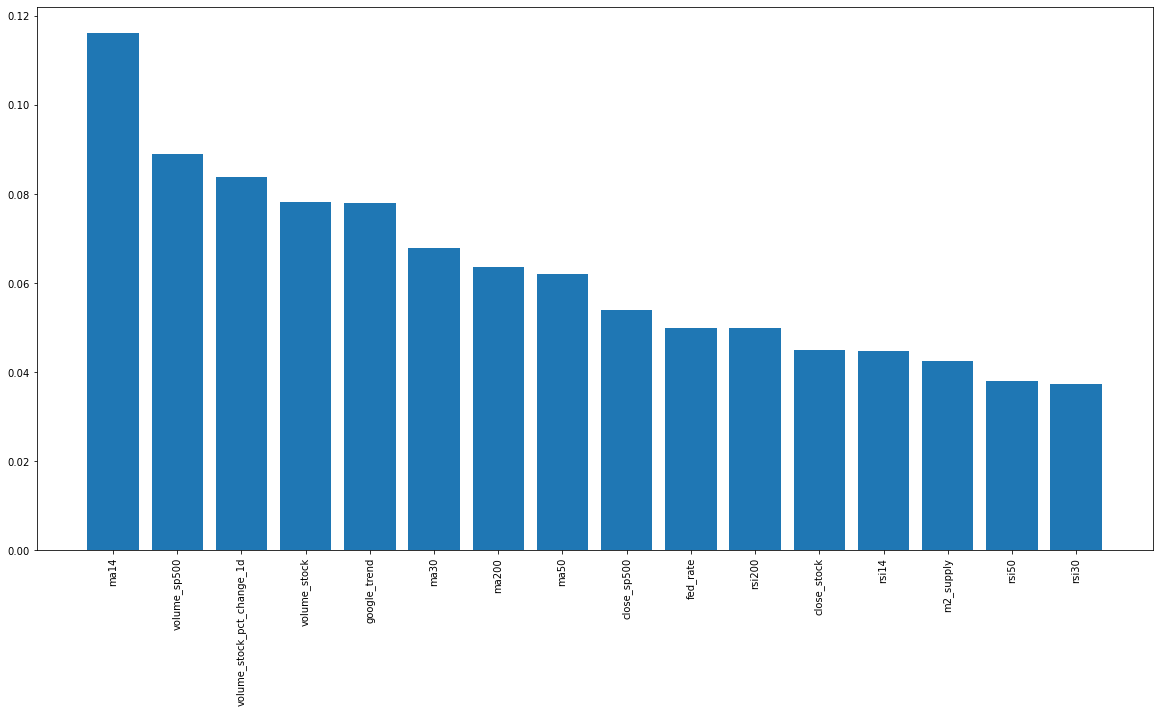

In [14]:
#Train and evaluate Random Forest
random_forest = RandomForestRegressor(random_state=100)
pred = train_and_evaluate(random_forest,X,y)
predictions = np.append(predictions,pred)

R2 score for training set is 0.08
R2 score for test slice from 2021-11-05 to 2021-11-11 is 0.01
R2 score for test slice from 2021-11-05 to 2021-11-18 is -0.03
R2 score for test slice from 2021-11-05 to 2021-11-26 is -0.00
R2 score for test slice from 2021-11-05 to 2021-12-03 is -0.05
Average R2 score for test set is -0.02
Prediction change for stock MSFT on the next open-market day after 2021-12-03 is: 0.10%


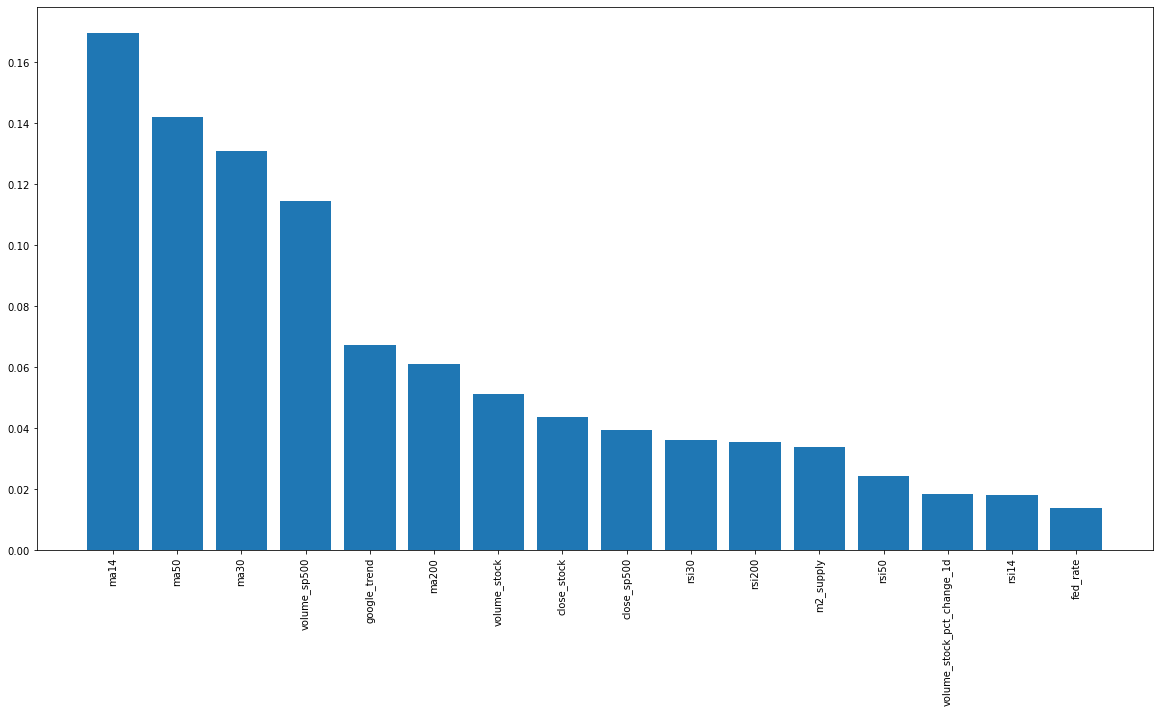

In [15]:
#Train and evaluate Gradient Boosting
gbr = GradientBoostingRegressor(max_features=3,
                                learning_rate=0.01,
                                n_estimators=100,                                
                                subsample=0.6,
                                random_state=100)
pred = train_and_evaluate(gbr,X,y)
predictions = np.append(predictions,pred)

In [16]:
#Train and evaluate KNN
knn = KNeighborsRegressor(n_neighbors=3)
pred = train_and_evaluate(knn,X,y,scaled=True)
predictions = np.append(predictions,pred)

R2 score for training set is 0.42
R2 score for test slice from 2021-11-05 to 2021-11-11 is -0.59
R2 score for test slice from 2021-11-05 to 2021-11-18 is -1.16
R2 score for test slice from 2021-11-05 to 2021-11-26 is -0.41
R2 score for test slice from 2021-11-05 to 2021-12-03 is -0.69
Average R2 score for test set is -0.71
Prediction change for stock MSFT on the next open-market day after 2021-12-03 is: -1.84%


## AR(1) Model
I also tried an AR(1) model for forecasting since some of the stastistical tests performed on the data indicated that this model may have a good predictive power in our data set. The tests and predictions are listed below:

In [17]:
from statsmodels.tsa.stattools import adfuller
# Compute and print ADF p-value
result = adfuller(df['close_stock'])
print("The p-value for the ADF test is ", result[1])

The p-value for the ADF test is  1.0


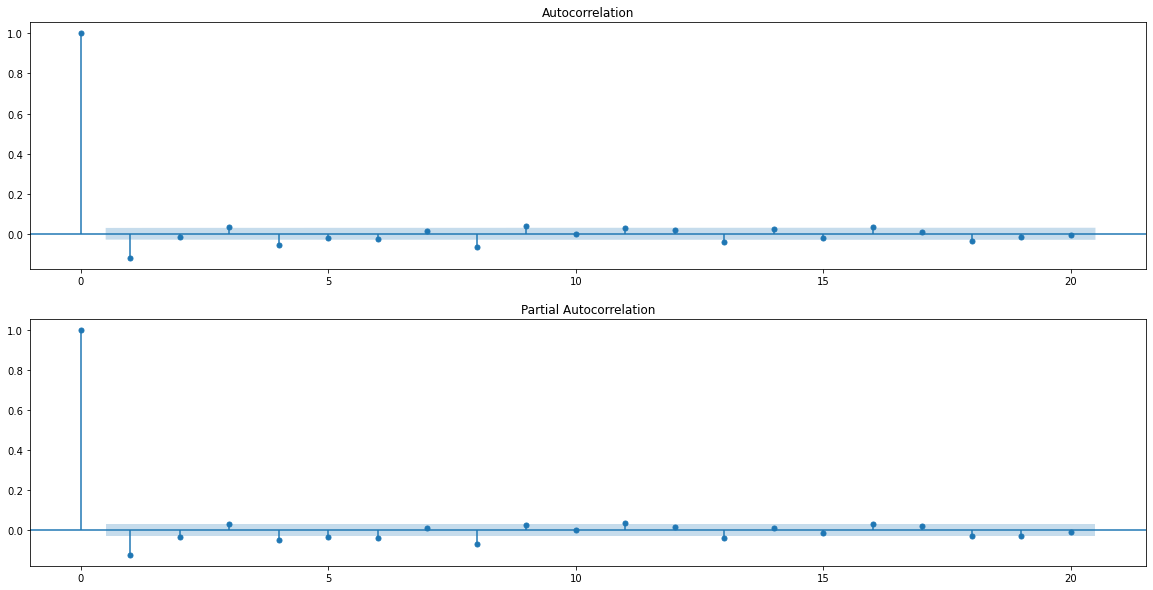

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
diff = pd.DataFrame(df['close_stock'].pct_change()).dropna()

# Plot the ACF and PACF on the same page
fig, axes = plt.subplots(2,1)

# Plot the ACF
plot_acf(diff, lags=20, ax=axes[0])

# Plot the PACF
plot_pacf(diff, lags=20, ax=axes[1])
plt.show()

In [19]:
warnings.filterwarnings('ignore')
# Import the module for estimating an ARMA model
from statsmodels.tsa.arima_model import ARMA

# Fit the data to an AR(1) model and print AIC:
mod_ar1 = ARMA(diff, order=(1, 0))
res_ar1 = mod_ar1.fit()
print("The AIC for an AR(1) is: ", res_ar1.aic)

# Fit the data to an AR(2) model and print AIC:
mod_ar2 = ARMA(diff, order=(2, 0))
res_ar2 = mod_ar2.fit()
print("The AIC for an AR(2) is: ", res_ar2.aic)

# Fit the data to an ARMA(1,1) model and print AIC:
mod_arma11 = ARMA(diff,order=(1,1))
res_arma11 = mod_arma11.fit()
print("The AIC for an ARMA(1,1) is: ", res_arma11.aic)

The AIC for an AR(1) is:  -24156.289586393556
The AIC for an AR(2) is:  -24159.19758160253
The AIC for an ARMA(1,1) is:  -24157.98211849034


Based on the AIC score, the best model seems to be an AR(1), hence we are going to use that model to forescasting

Prediction change for stock MSFT on the next open-market day after 2021-12-03 is: 0.33%


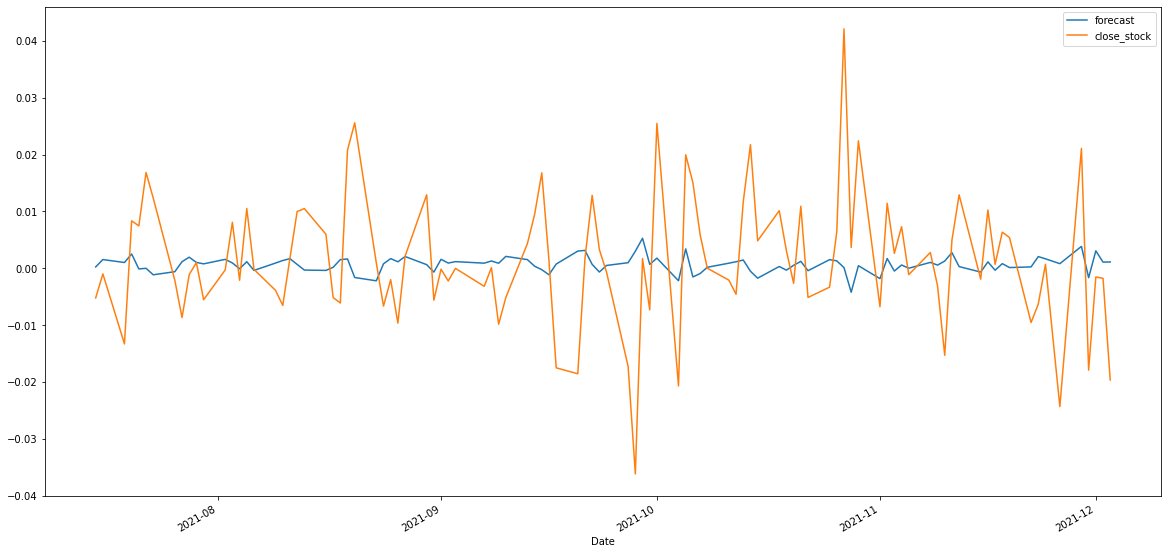

In [20]:
#Print prediction for AR(1)
prediction = res_ar1.predict(start=len(diff)-1,end=len(diff)).iloc[1] * 100
print('Prediction change for stock '+stock_ticker + ' on the next open-market day after '\
      + df.iloc[-1].name.strftime('%Y-%m-%d') + ' is: {:.2f}%'.format(prediction))
predictions = np.append(predictions,prediction)

#Plot the AR(1) prediction
res_ar1.plot_predict(start=len(diff)-100)
plt.show()

In [21]:
predicted_day = df.iloc[-1].name.strftime('%Y-%m-%d')  

#Print Random Forest prediction
print('Random Forest prediction change for stock '+stock_ticker + ' on the next open-market day after ' +\
      predicted_day + ' is: {:.2f}%'.format(predictions[0]))

#Print Gradient Boosting prediction
print('Gradient Boosting prediction change for stock '+stock_ticker + ' on the next open-market day after ' +\
      predicted_day + ' is: {:.2f}%'.format(predictions[1]))

#Print KNN prediction
print('KNN prediction change for stock '+stock_ticker + ' on the next open-market day after ' +\
      predicted_day + ' is: {:.2f}%'.format(predictions[2]))

#Print AR(1) prediction
print('AR(1) prediction change for stock '+stock_ticker + ' on the next open-market day after ' +\
      predicted_day + ' is: {:.2f}%'.format(predictions[3]))

#Print actual change
print('\nActual change on the next open-market day after {} up to this moment is {:.2f}%\nMarket still open: {}'\
      .format(predicted_day,actual_change,is_market_open))

Random Forest prediction change for stock MSFT on the next open-market day after 2021-12-03 is: -0.06%
Gradient Boosting prediction change for stock MSFT on the next open-market day after 2021-12-03 is: 0.10%
KNN prediction change for stock MSFT on the next open-market day after 2021-12-03 is: -1.84%
AR(1) prediction change for stock MSFT on the next open-market day after 2021-12-03 is: 0.33%

Actual change on the next open-market day after 2021-12-03 up to this moment is 0.25%
Market still open: True


## Results
The models we created as part of this work are not very good predictors. The average R2 score of the 4 test slices is usually a negative value which means that our model is worse than always predicting the mean of the stock price returns. This is pretty similar to what I expected in the EDA since the <b>stock returns are normally distributed with mean 0 and with a constant (and small) value for standard deviation so always predicting the mean sounds reasonable</b>. Overall I am not completely satisfied with the model predictions, but I am satisfied with the learning and investigation I did to build them.<br><br>
Ignoring the fact that the models are not good predictors, and just comparing them for learning purposes, we can see that surprisingly, the most accurate model for forecasting the Stock Price of the ticker we used as example was KNN, the second best was Random Forest and the worst prediction was provided by the Gradient Boosting model. I was expecting the exact inverse order in the accuracy of the models, but <b>is important to mention that the process was also ran for other tickers and the most accurate model vary for each stock or even for each date</b>, so we can not state that KNN will always be the most accurate.<br><br>
These models also suggest that the <b>Interest Rate and the Money Supply are not as important to
forecast the stock price as I initially thought</b>. The technical factors are by far the most important
features in the models we created. The Google trends fall in the middle of the importance in both
models in which we can measure the feature importances.<br><br>
I verified that it is pretty <b>difficult to create a model that predicts the stock prices</b>, since the time series data is a <b>Random Walk</b> even when using data from multiple sources and backed up by economic theory; so the best prediction for the next day price is simply the price of the stock in the previous day (i.e. 0 percentage change). I am not surprised, if it were easy, everyone or at least the people that know how to forecast time series would be rich. Due all these inconsistencies, I would not use this model as guide to buy or sell stocks.